## 1. Error analysis for nbs from github - the stack v1

https://huggingface.co/datasets/bigcode/the-stack-dedup/tree/main/data/jupyter-notebook


In [2]:
# read in all errors from the file
import pandas as pd

df2_err = pd.read_csv('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_all_p3.csv', encoding='utf-8')
df2_err = df2_err[df2_err['language']=='python'][['fname','ename','evalue','traceback']]
df2_err.head()

,fname,ename,evalue,traceback
0,00000-101-cookie-clicker-v2-checkpoint.ipynb,KeyboardInterrupt,NaN,['--------------------------------------------...
1,00000-1012-demand-forecasting-data-prep-from-s...,OperationalError,"FATAL: no pg_hba.conf entry for host ""75.166....",['--------------------------------------------...
2,00000-1017-heatmapseq2seq.ipynb,ValueError,"x and y must have same first dimension, but ha...",['--------------------------------------------...
3,00000-1023-crawler-20190515-20190516.ipynb,ConnectionError,HTTPSConnectionPool(host='www.backpackers.com....,['--------------------------------------------...
4,00000-1033-peer-solution-predicting-survival-t...,URLError,<urlopen error [Errno 11001] getaddrinfo failed>,['--------------------------------------------...


In [3]:
df2_err.count()

fname        177540
ename        177396
evalue       158707
traceback    177540
dtype: int64

In [6]:
df2_err["fname"].nunique()

109063

In [5]:
df2_err["ename"].nunique()

1520

<Axes: xlabel='ename'>

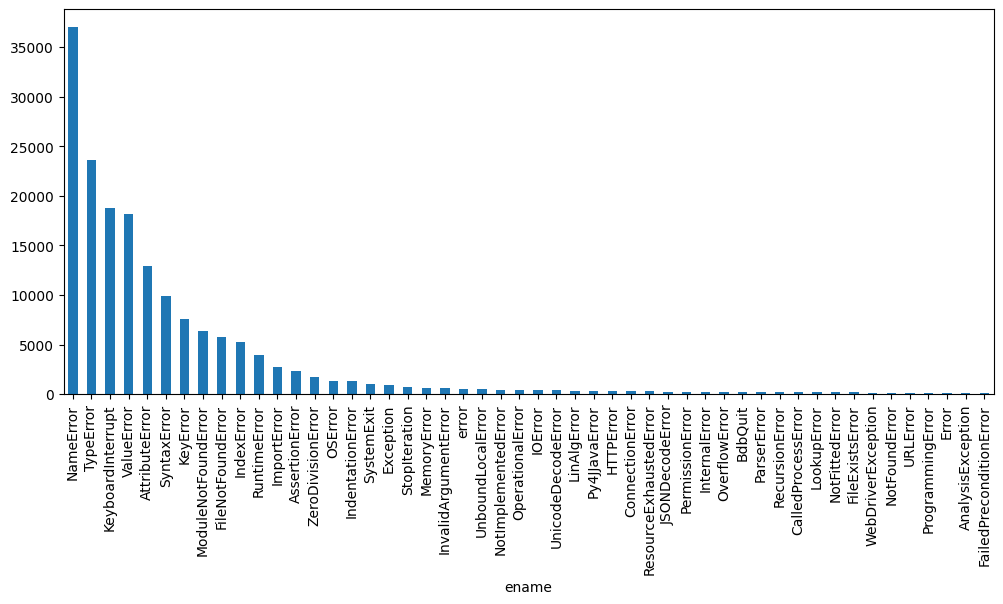

In [7]:
df2_err["ename"].groupby([df2_err["ename"]]).count().sort_values(ascending=0)[:50].plot(kind="bar", figsize=(12,5))

<Axes: xlabel='ename'>

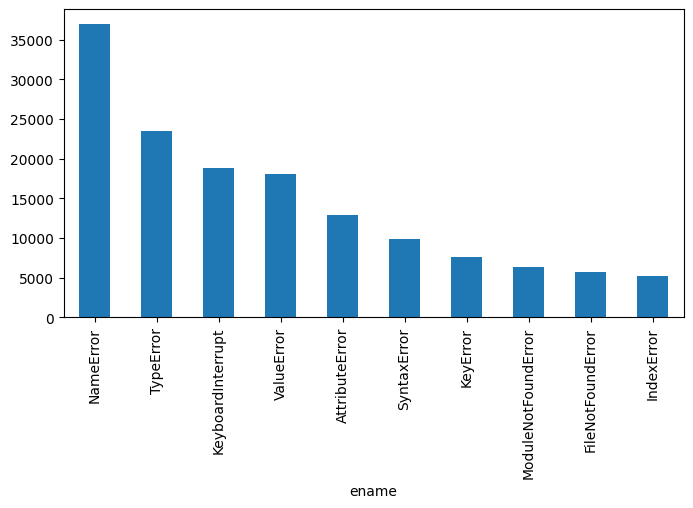

In [8]:
df2_err["ename"].groupby([df2_err["ename"]]).count().sort_values(ascending=0)[:10].plot(kind="bar", figsize=(8,4))

### 1.1 Clustering with K-Means

In [ ]:
#!python -m spacy download en_core_web_trf

In [4]:
import pandas as pd 
import cluster_util

df2_err = pd.read_csv('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_all_p3.csv', encoding='utf-8')
df2_err = df2_err[df2_err['language']=='python'][['fname','ename','evalue','traceback']]

#### NameError, evalue

In [3]:
import spacy

In [ ]:
import re
nlp = spacy.load('en_core_web_trf')

def preprocess_text(text, nlp):
    # remove special chars
    text = re.sub("[^A-Za-z0-9_]+", " ", str(text))
    
    # remove stopwords
    doc = nlp(text)
    res = []
    for token in doc:
        if token.is_stop != True:
            res.append(token.text.lower())
    return " ".join(res)

df2_err['evalue_tokenized'] = df2_err['evalue'].apply(preprocess_text, nlp=nlp)

In [ ]:
df2_err

In [ ]:
df2_err.to_csv("C:/Users/yirwa29/Downloads/Dataset-Nb/nbdata_k_error/nberror_g_evaluetokenized.csv", index=False, encoding='utf-8')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer 

vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(df2_err['evalue_tokenized']).toarray()

In [ ]:
pip install sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-MiniLM-L6-v2")
X_transformers = np.vstack(df2_err['evalue_tokenized'].apply(lambda text: model.encode(text, convert_to_numpy=True).flatten()))

In [ ]:
from numpy import savetxt, loadtxt
import gensim

glove_vectors = gensim.downloader.load('conceptnet-numberbatch-17-06-300') # https://github.com/piskvorky/gensim-data
print('Loaded %s word vectors from GloVe.' % len(glove_vectors))  # 1,193,514

def sentence_embedding(sentence, max_length = 5000, embedding_dim = 200):
    words = sentence.split()
    num_words = min(len(words), max_length)
    embedding_sentence = np.zeros((num_words, embedding_dim))
    
    for i in range(num_words):
        word = words[i]
        if word in glove_vectors.key_to_index:
            embedding_sentence[i] = glove_vectors[word]
            
    return embedding_sentence.flatten()

X_glove = np.vstack(df['evalue_tokenized'].apply(lambda sentence: sentence_embedding(sentence)))

In [6]:
df2_err_ename = df2_err[df2_err['ename']=='NameError']
err_descs = df2_err_ename['evalue'].values.astype('U') # traceback: memory error

In [ ]:
# elbow method for optimal value of k in kmeans

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_
    
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [ ]:
num_clusters = 2
_, res, _ = cluster_util.cluster_kmeans(input_texts=err_descs, n_clusters=num_clusters) # km_model, res, vectorized_descs
# plot the results 
# cluster_util.plot_clusters(vectorized_descs, num_clusters, km_model.labels_)

In [7]:
cluster_util.print_clusters(num_clusters, res)

cluster 0 has 50 samples
                              errdesc  cluster
36857     name 'error' is not defined        0
30187     name 'error' is not defined        0
166       name 'error' is not defined        0
17326     name 'error' is not defined        0
694       name 'error' is not defined        0
1979      name 'error' is not defined        0
32475     name 'error' is not defined        0
34312     name 'error' is not defined        0
31205  This is the raised name error.        0
25804     name 'error' is not defined        0


cluster 1 has 36955 samples
                                   errdesc  cluster
7019              name 'df' is not defined        1
31697           name 'tmax' is not defined        1
20632            name 'nlp' is not defined        1
10551             name 'np' is not defined        1
35938             name 'bb' is not defined        1
11316          name 'model' is not defined        1
23866           name 'set1' is not defined        1
5088        

##### Note:

found **ignored** values in evalue column in a cluster, but they seem have evalue in traceback. I extracted those and retried.

##### No obvious clusters found in NameError.

#### TypeError, evalue

In [16]:
df2_err_ename = df2_err[df2_err['ename']=='TypeError']
err_descs = df2_err_ename['evalue'].values.astype('U') # traceback: memory error

In [17]:
num_clusters = 10
_, res, _ = cluster_util.cluster_kmeans(input_texts=err_descs, n_clusters=num_clusters, max_iter=1000)
# plot the results 
# cluster_util.plot_clusters(vectorized_descs, num_clusters, km_model.labels_)
cluster_util.print_clusters(num_clusters, res)

cluster 0 has 1488 samples
                                             errdesc  cluster
11659    can only concatenate str (not "int") to str        0
8625                    'int' object is not iterable        0
4428                    'str' object is not callable        0
12026    can only concatenate str (not "int") to str        0
21289    can only concatenate str (not "int") to str        0
6557           cannot unpack non-iterable int object        0
14131                   'str' object is not callable        0
9622                            must be str, not int        0
9063     can only concatenate str (not "int") to str        0
16412  can only concatenate str (not "float") to str        0


cluster 1 has 2519 samples
                                                 errdesc  cluster
18588  emptyFunction() takes 0 positional arguments b...        1
20039  field() takes 0 positional arguments but 1 was...        1
1419   emptyFunction() takes 0 positional arguments b...        

##### Note:

10 clusters for TypeError:

    1. can only concatenate *something* to str
    2. *something* missing *somenumber* required positional arguments...
    3. *something* object is not callable/iterable/has no len()
    4. *something* object does not support item assignment
    5. others
    6. list/tuple indices must be integers or slices, not str
    7. unhashable type: 'list/dict/slice', can only concatenate list (not "int") to list
    8. unsupported operand type(s) for -: 'str' and '..
    9. *something* object cannot be interpreted/converted...
    10. '<' not supported between instances of 'str' a..

#### ValueError, evalue

In [2]:
df2_err_ename = df2_err[df2_err['ename']=='ValueError']
err_descs = df2_err_ename['evalue'].values.astype('U')

In [22]:
num_clusters = 8
_, res, _ = cluster_util.cluster_kmeans(input_texts=err_descs, n_clusters=num_clusters, max_iter=1000)
# plot the results 
# cluster_util.plot_clusters(vectorized_descs, num_clusters, km_model.labels_)
cluster_util.print_clusters(num_clusters, res)

cluster 0 has 716 samples
                                               errdesc  cluster
17556           too many values to unpack (expected 4)        0
17832           too many values to unpack (expected 2)        0
2238            too many values to unpack (expected 2)        0
1883            too many values to unpack (expected 4)        0
9730   not enough values to unpack (expected 5, got 1)        0
8018            too many values to unpack (expected 2)        0
5165   not enough values to unpack (expected 3, got 1)        0
17923           too many values to unpack (expected 2)        0
179             too many values to unpack (expected 2)        0
6100                     All values must >= 1 and <= 9        0


cluster 1 has 965 samples
                                                 errdesc  cluster
1171      invalid literal for int() with base 10: 'Good'        1
12451        invalid literal for int() with base 10: ' '        1
11841  invalid literal for int() with base 1

In [10]:
# a little try on DBSCAN. doesn't seem to work
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer 


vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(err_descs)

dbscan = DBSCAN(eps=0.2, min_samples=100)
dbscan.fit(vectors)

cluster_labels = dbscan.labels_

no_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)

print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 17
Estimated no. of noise points: 14448


##### Note:

8 clusters for ValueError:

    1. too many values to unpack
    2. invalid literal for int() with base 10
    3. setting an array element with a sequence, The truth value of a Series is ambiguous/with more than one value..
    4. others
    5. operands could not be broadcast together ...
    6. Input contains NaN, infinity or..
    7. array shape mismatch
    8. could not convert *sometype* to *sometype* ..

#### AttributeError, evalue

In [23]:
df2_err_ename = df2_err[df2_err['ename']=='AttributeError']
err_descs = df2_err_ename['evalue'].values.astype('U')

In [24]:
num_clusters = 2
_, res, _ = cluster_util.cluster_kmeans(input_texts=err_descs, n_clusters=num_clusters, max_iter=500)
cluster_util.print_clusters(num_clusters, res)

cluster 0 has 855 samples
                                                 errdesc  cluster
12354         'DataFrame' object has no attribute 'Date'        0
2388           'DataFrame' object has no attribute 'get'        0
11488     'DataFrame' object has no attribute 'pred_sgd'        0
5408            'DataFrame' object has no attribute 'ix'        0
2060        'DataFrame' object has no attribute 'unique'        0
12927          'DataFrame' object has no attribute 'str'        0
1511          'DataFrame' object has no attribute 'prob'        0
1765   'DataFrame' object has no attribute 'fivegram_...        0
5366           'DataFrame' object has no attribute 'hit'        0
12886       'DataFrame' object has no attribute 'equity'        0


cluster 1 has 12076 samples
                                                 errdesc  cluster
6759           'Person' object has no attribute '__name'        1
7564         module 'numpy' has no attribute 'heaviside'        1
4495                

##### Note: No obvious clusters in AttributeError

#### SyntaxError, evalue

In [25]:
df2_err_ename = df2_err[df2_err['ename']=='SyntaxError']
err_descs = df2_err_ename['evalue'].values.astype('U')

In [27]:
num_clusters = 10
_, res, _ = cluster_util.cluster_kmeans(input_texts=err_descs, n_clusters=num_clusters, max_iter=500)
cluster_util.print_clusters(num_clusters, res)

cluster 0 has 77 samples
                                                errdesc  cluster
9201  keyword can't be an expression (<ipython-input...        0
7244  f-string expression part cannot include a back...        0
2900  keyword can't be an expression (<ipython-input...        0
6632  keyword can't be an expression (<ipython-input...        0
2495  keyword can't be an expression (<ipython-input...        0
7260  can't use starred expression here (<ipython-in...        0
6006  keyword can't be an expression (<ipython-input...        0
7055  can't use starred expression here (<ipython-in...        0
1262  keyword can't be an expression (<ipython-input...        0
461   keyword can't be an expression (<ipython-input...        0


cluster 1 has 58 samples
                                                errdesc  cluster
8337  invalid syntax (<ipython-input-35-fba0d58980c0...        1
7267  'return' outside function (<ipython-input-8-6e...        1
951   invalid syntax (<ipython-input-3

#### Some mixed error types, evalue

In [28]:
df2_err_ename = df2_err[df2_err['ename'].isin(['Error', 'ERROR', 'error'])]
err_descs = df2_err_ename['evalue'].values.astype('U')

In [35]:
num_clusters = 7
_, res, _ = cluster_util.cluster_kmeans(input_texts=err_descs, n_clusters=num_clusters, max_iter=800)
cluster_util.print_clusters(num_clusters, res)

cluster 0 has 220 samples
                                                errdesc  cluster
121   Error in eval(expr, envir, enclos): objet 'hqw...        0
1719  Error in eval(expr, envir, enclos): object 're...        0
1859                                      compile_error        0
1401  Error in eval(expr, envir, enclos): wrong resu...        0
881                                       compile_error        0
1320  Error in eval(expr, envir, enclos): object 'wm...        0
2120  Error in get(name, envir = envir): object 's_l...        0
676   Error in eval(expr, envir, enclos): object 'me...        0
1627  Error in eval(expr, envir, enclos): object '.....        0
2083  Error in eval(expr, envir, enclos): Objekt 'nu...        0


cluster 1 has 140 samples
                                                errdesc  cluster
123   Error in library("scHOT"): there is no package...        1
1063  Error in library(prophet): there is no package...        1
33    Error in library(mxnet): there

## 2. Error analysis for nbs from kaggle


In [1]:
# read in all errors from the file
import pandas as pd

path_err = 'C:/Users/yirwa29/Downloads/Dataset-Nb/nbdata_k_error/nberror_k.csv'
df_err = pd.read_csv(path_err, encoding='utf-8')